# Overview
- Denver count of crimes near universities are significantly smaller than SF, reason being SF being more high densely populated and Denver only has data from 2014 but SF has data from 2003
  - Denver: 778
  - SF: 3398

- Hence, SF's data is used as the main source of statistical inference as a greater sample of data is more reliable and Denver data set is mainly use to see if there are agreeable insights with SF's analysis to increase conviction of statistical analysis.

Main Findings:

- Larceny is the most commonly occured crime
- During a school semester,
  - On weekdays, crime levels are consistently higher from 0800-0059 the next day
  - On weekends, crime levels are consistently high around midnight from 0000-0259 and from 2300-235.
  - On weekdays, Larceny Theft occurrence is consistently high from 0800-0059 the next day
  - On weekends,  Larceny Theft occurrence is consistently higher from midnight 0000-0159 and 1300-2359

- During a non-school period,
  - On weekdays, crime levels are consistently high from 0900-1859 the next day
  - On weekends, crime levels are consistently higher around midnight 0000-1259 and from 1000-2359.
  - On weekdays, Larceny Theft occurrence is consistently high from 1200-2259




In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS, cluster_optics_dbscan
from plotly.subplots import make_subplots
from scipy.stats import shapiro
import scipy.stats as stats

pd.set_option('display.max_columns', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading of 2003-2023 file

In [48]:
raw_df = pd.read_pickle('/content/drive/My Drive/ColabNotebooks/crimes_near_universities_2003_2023.pkl')
raw_df.head()

,datetime,Incident Category,Longitude,Latitude
2114,2022-10-28 02:50:00,Lost Property,-122.398564,37.788981
2657,2023-03-24 15:30:00,Other Miscellaneous,-122.398564,37.788981
4528,2023-09-19 23:15:00,Larceny Theft,-122.400503,37.787450
5548,2023-10-03 06:29:00,Malicious Mischief,-122.398564,37.788981
5556,2023-10-03 10:00:00,Larceny Theft,-122.400809,37.787699


In [49]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3398 entries, 2114 to 2128549
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   datetime           3398 non-null   datetime64[ns]
 1   Incident Category  3398 non-null   object        
 2   Longitude          3398 non-null   float64       
 3   Latitude           3398 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 132.7+ KB


# Feature engineering for time-related features

In [50]:
import holidays

df = raw_df
df['date'] = df['datetime'].dt.date
df['year'] = df['datetime'].dt.year
df['hour'] = df['datetime'].dt.hour
df['dayOfWeek'] = df['datetime'].dt.dayofweek

conditions=[(df['hour']>=7)& (df['hour']<11),
            (df['hour']>=11) & (df['hour']<14),
            (df['hour']>=14) & (df['hour']<17),
            (df['hour']>=17) & (df['hour']<21)
            ]
choices=['Morning Class', 'Lunch', 'Afternoon Class', 'Dinner']
df['TimeOfDay'] = np.select(conditions, choices, default='Rest')

def int_to_day_name(int_value):
    day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    return day_names[int_value]

# Apply the function to the DataFrame column
df['dayOfWeek'] = df['dayOfWeek'].apply(int_to_day_name)

df['IsWeekend'] = df['datetime'].dt.dayofweek >= 5

us_holidays = holidays.US(years=df['datetime'].dt.year.unique().tolist())
df['IsHoliday'] = df['datetime'].dt.date.isin(us_holidays)

# school_days = [
#     (pd.Timestamp('2023-08-15'), pd.Timestamp('2023-12-15')),
#     (pd.Timestamp('2023-01-15'), pd.Timestamp('2023-05-15')),
# ]
# def is_school_day(date):
#     for start_date, end_date in school_days:
#         if start_date <= date <= end_date:
#             return True
#     return False
# df['IsSchoolDay'] = df['datetime'].apply(is_school_day)

df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.days_in_month

conditions = [(df['month']==6), (df['month']==7), (df['month']==5) & (df['day']>15), (df['month']==8) & (df['day']<15),
              (df['month']==12) & (df['day']>15), (df['month']==1) & (df['day']<15)
              ]
choices=[False,False,False,False,False,False]
df['IsSchoolDay'] = np.select(conditions, choices, True)
df.head()

,datetime,Incident Category,Longitude,Latitude,date,year,hour,dayOfWeek,TimeOfDay,IsWeekend,IsHoliday,month,day,IsSchoolDay
2114,2022-10-28 02:50:00,Lost Property,-122.398564,37.788981,2022-10-28,2022,2,Friday,Rest,False,False,10,31,True
2657,2023-03-24 15:30:00,Other Miscellaneous,-122.398564,37.788981,2023-03-24,2023,15,Friday,Afternoon Class,False,False,3,31,True
4528,2023-09-19 23:15:00,Larceny Theft,-122.400503,37.787450,2023-09-19,2023,23,Tuesday,Rest,False,False,9,30,True
5548,2023-10-03 06:29:00,Malicious Mischief,-122.398564,37.788981,2023-10-03,2023,6,Tuesday,Rest,False,False,10,31,True
5556,2023-10-03 10:00:00,Larceny Theft,-122.400809,37.787699,2023-10-03,2023,10,Tuesday,Morning Class,False,False,10,31,True


In [51]:
df[df['IsSchoolDay']==False]

,datetime,Incident Category,Longitude,Latitude,date,year,hour,dayOfWeek,TimeOfDay,IsWeekend,IsHoliday,month,day,IsSchoolDay
6266,2022-12-30 17:00:00,Malicious Mischief,-122.409481,37.775451,2022-12-30,2022,17,Friday,Dinner,False,False,12,31,False
31190,2023-05-06 12:00:00,Larceny Theft,-122.432385,37.790044,2023-05-06,2023,12,Saturday,Lunch,True,False,5,31,False
32507,2023-05-12 07:30:00,Missing Person,-122.409481,37.775451,2023-05-12,2023,7,Friday,Morning Class,False,False,5,31,False
36926,2023-05-23 12:40:00,Motor Vehicle Theft,-122.400503,37.787450,2023-05-23,2023,12,Tuesday,Lunch,False,False,5,31,False
37622,2023-05-24 14:00:00,Recovered Vehicle,-122.451163,37.774249,2023-05-24,2023,14,Wednesday,Afternoon Class,False,False,5,31,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114020,2017-07-21 22:00:00,Lost Property,-122.400804,37.786441,2017-07-21,2017,22,Friday,Rest,False,False,7,31,False
2114162,2017-07-07 00:20:00,Assault,-122.400861,37.787091,2017-07-07,2017,0,Friday,Rest,False,False,7,31,False
2116143,2017-05-12 17:20:00,Larceny Theft,-122.409046,37.775176,2017-05-12,2017,17,Friday,Dinner,False,False,5,31,False
2116658,2017-05-26 17:40:00,Other,-122.400861,37.787091,2017-05-26,2017,17,Friday,Dinner,False,False,5,31,False


In [52]:
df['datetime'].describe()

count                    3398
unique                   2822
top       2005-05-11 10:40:00
freq                        8
first     2003-01-01 06:48:00
last      2023-10-25 18:01:00
Name: datetime, dtype: object

# Map visual

In [53]:
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import BallTree
import folium
import plotly.graph_objects as go

# sourced from latitude.to
# can opt to add more if necessary
coords_universities = [
                  ('San Francisco State University', 37.720663784, -122.474498102),
                   ('University of San Francisco', 37.774330236, -122.451164862),
                    ('University of California, San Francisco', 37.7257157, -122.4501783),
                     ('University of California, San Francisco', 37.7579886347, -122.455121513),
                      ('Academy of Art University', 37.78785, -122.40065),
                       ('Golden Gate University', 37.78923, -122.3988),
                        ('University of California, Hastings College of the Law', 37.7751268995, -122.409201697),
                         ('California College of the Arts' , 37.83593, -122.2503),
                          ('University of the Pacific Arthur A. Dugoni School of Dentistry,', 37.79, -122.432),
                  ('California State University East Bay', 37.6575, -122.0568 ),
                          ("Saint Mary's College of California",37.8409,  -122.1089 ),
                          ("San Francisco Conservatory of Music", 37.7755, -122.4204),
                          ("Hult International Business School", 37.8026, -122.4032),
                          ("Presidio Graduate School", 37.7869, -122.4007),
                          ("California Institute of Integral Studies",37.7747, -122.4164)
  ]

universities_df = pd.DataFrame(coords_universities, columns=['University', 'Latitude', 'Longitude'])
universities_gdf = gpd.GeoDataFrame(universities_df, geometry=[Point(xy) for xy in zip(universities_df.Longitude, universities_df.Latitude)])

# Calculate average latitude and longitude for map centering
average_lat, average_lon = universities_gdf['Latitude'].mean(), universities_gdf['Longitude'].mean()

# # Create a base map
# m = folium.Map(location=[average_lat, average_lon], zoom_start=13)

# # Add points for crimes and universities
# for idx, row in df.iterrows():
#     folium.Marker([row['Latitude'], row['Longitude']], icon=folium.Icon(color='red')).add_to(m)
# for idx, row in universities_gdf.iterrows():
#     folium.Marker([row['Latitude'], row['Longitude']], icon=folium.Icon(color='blue')).add_to(m)

# # Display the map
# m

# Time

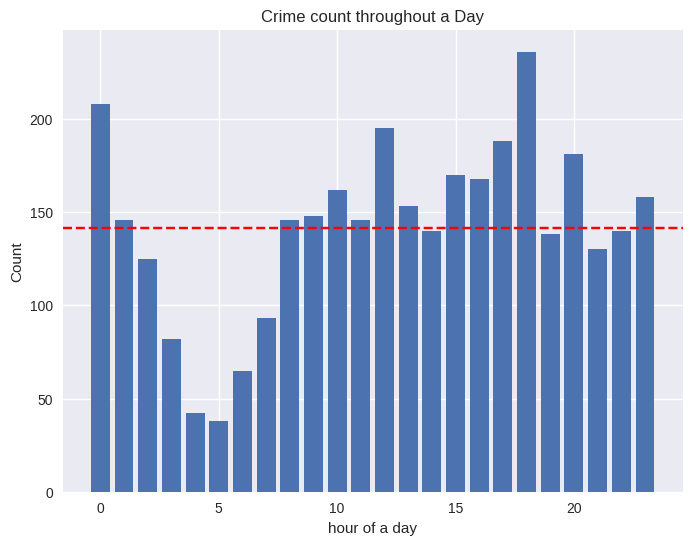

In [54]:
crimes_near_universities = df
value_counts = crimes_near_universities['hour'].value_counts()

# Create a bar plot (histogram)
plt.figure(figsize=(8, 6))
plt.bar(value_counts.index, value_counts.values)

mean_value = value_counts.mean()
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')

# Adding labels and title
plt.xlabel('hour of a day')
plt.ylabel('Count')
plt.title('Crime count throughout a Day')

# Show the plot
plt.show()

In [55]:
# crimes_near_universities.to_csv('/content/drive/My Drive/ColabNotebooks/crimes_near_universities_beforeClustering.csv')

In [56]:
# May be interesting to explore these
# bins = [0, 6, 12, 18, 21, 24]
# labels = ['Midnight', 'Morning', 'Afternoon', 'Evening', 'Night']
# crimes_near_universities['TimeOfDay'] = pd.cut(crimes_near_universities['hour'], bins=bins, labels=labels, right=False)

a = crimes_near_universities.groupby('TimeOfDay').size()
a = a/a.sum() * 100
a = a.reset_index(name = 'Count')

fig = px.line(a, x="TimeOfDay", y="Count")

fig.update_layout(
    title='Distribution of Crime Categories by Time of Day(%)',
    xaxis_title='Day of Week',
    yaxis_title='Percentage (%)',
    xaxis_tickangle= -60
)

fig.show()


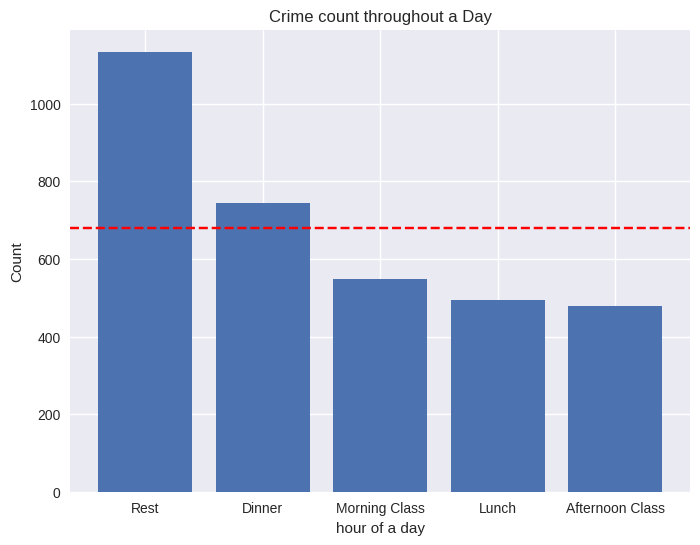

In [57]:
value_counts = crimes_near_universities['TimeOfDay'].value_counts()

# Create a bar plot (histogram)
plt.figure(figsize=(8, 6))
plt.bar(value_counts.index, value_counts.values)

mean_value = value_counts.mean()
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')

# Adding labels and title
plt.xlabel('hour of a day')
plt.ylabel('Count')
plt.title('Crime count throughout a Day')

# Show the plot
plt.show()

# Time and category

In [58]:
import plotly.express as px
occurrences = crimes_near_universities.groupby(["hour", "Incident Category"]).size().reset_index(name="Occurrences")

# Create a scatter plot with varying dot sizes
fig = px.scatter(occurrences, x="hour", y="Incident Category", size="Occurrences")

fig.show()


# Category and holiday/school

In [59]:
occurrences = crimes_near_universities.groupby(["IsHoliday"]).size().reset_index(name="Occurrences")

fig = px.pie(occurrences, values='Occurrences', names='IsHoliday')
fig.show()

Too insignificant so drop column IsHoliday

In [60]:
crimes_near_universities.drop('IsHoliday', axis=1, inplace=True)

# Category and IsSchoolDay

In [61]:
occurrences = crimes_near_universities.groupby(["IsSchoolDay"]).size().reset_index(name="Occurrences")

fig = px.pie(occurrences, values='Occurrences', names='IsSchoolDay')
fig.show()

In [62]:
occurrences = crimes_near_universities.groupby(["Incident Category", 'IsSchoolDay']).size().reset_index(name="Occurrences")

# Create a scatter plot with varying dot sizes
fig = px.scatter(occurrences, x="IsSchoolDay", y="Incident Category", size="Occurrences")

fig.show()

# Category and IsWeekend

In [63]:
occurrences = crimes_near_universities.groupby(["IsWeekend"]).size().reset_index(name="Occurrences")

fig = px.pie(occurrences, values='Occurrences', names='IsWeekend')
fig.show()

In [64]:
occurrences = crimes_near_universities.groupby(["Incident Category", "IsWeekend", 'IsSchoolDay']).size().reset_index(name="Occurrences")

# Create a scatter plot with varying dot sizes
fig = px.scatter(occurrences, x="IsWeekend", y="Incident Category", size="Occurrences", color='IsSchoolDay')

fig.show()

# Category and dayOfWeek

In [65]:
occurrences = crimes_near_universities.groupby(["dayOfWeek"]).size().reset_index(name="Occurrences")

fig = px.pie(occurrences, values='Occurrences', names='dayOfWeek')
fig.show()

In [66]:
occurrences = crimes_near_universities.groupby(["Incident Category", "dayOfWeek"]).size().reset_index(name="Occurrences")

# Create a scatter plot with varying dot sizes
fig = px.scatter(occurrences, x="dayOfWeek", y="Incident Category", size="Occurrences")

fig.show()

In [67]:
occurrences = crimes_near_universities.groupby(["dayOfWeek"]).size().reset_index(name="Occurrences")

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a bar chart with the specified order
fig = px.bar(
    occurrences,
    x="dayOfWeek",
    y="Occurrences",
    category_orders={"dayOfWeek": day_order},
    title='Occurrences by Day of Week',
)

fig.show()

In [68]:
crimes_near_universities['DayOfWeek_num'] = crimes_near_universities['datetime'].dt.day_of_week
near_uni_counts = crimes_near_universities['DayOfWeek_num'].value_counts(normalize = True) * 100

df = pd.DataFrame({'Near Universities': near_uni_counts}).reset_index()
df.rename(columns={'index': 'DayOfWeek'}, inplace=True)
df.sort_values('DayOfWeek', inplace=True)
# days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=days_order, ordered=True)
# df = df.sort_values(by='DayOfWeek')

def int_to_day_name(int_value):
    day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    return day_names[int_value]

# Apply the function to the DataFrame column
df['DayOfWeek'] = df['DayOfWeek'].apply(int_to_day_name)

fig = go.Figure()

fig = px.line(df, x="DayOfWeek", y="Near Universities")


fig.update_layout(
    title='Distribution of Crime Categories by Day of Week(%)',
    xaxis_title='Day of Week',
    yaxis_title='Percentage (%)',
    # barmode='group',
    xaxis_tickangle= -60
)

fig.show()


# Category

In [69]:
occurrences = crimes_near_universities.groupby(["Incident Category"]).size().reset_index(name="Occurrences")

fig = px.pie(occurrences, values='Occurrences', names='Incident Category')
fig.show()


In [70]:
crimes_near_universities['Incident Category'].unique()

array(['Lost Property', 'Other Miscellaneous', 'Larceny Theft',
       'Malicious Mischief', 'Fraud', 'Burglary', 'Warrant', 'Other',
       'Non-Criminal', 'Miscellaneous Investigation', 'Missing Person',
       'Suspicious Occ', 'Motor Vehicle Theft', 'Recovered Vehicle',
       'Weapons Offense', 'Drug Offense', 'Embezzlement', 'Robbery',
       'Weapons Carrying Etc', 'Assault',
       'Offences Against The Family And Children', 'Traffic Violation',
       'Case Closure', 'Arson', 'Disorderly Conduct', 'Stolen Property',
       'Forgery And Counterfeiting', 'Other Offenses', 'Suicide',
       'Vandalism', 'Weapon Laws', 'Sex Offenses', 'Other MIscellaneous'],
      dtype=object)

Hence, Larceny Theft is the most common crime regardless of holiday or school semester

In [71]:
# crimes_near_universities.to_pickle('/content/drive/My Drive/ColabNotebooks/final_crimes_near_universities_2003_2023.pkl')

# K-Means Clustering for crimes near school
- As data will contain many dummy variables,


In [72]:
crimes_near_universities.head(n=2)

,datetime,Incident Category,Longitude,Latitude,date,year,hour,dayOfWeek,TimeOfDay,IsWeekend,month,day,IsSchoolDay,DayOfWeek_num
2114,2022-10-28 02:50:00,Lost Property,-122.398564,37.788981,2022-10-28,2022,2,Friday,Rest,False,10,31,True,4
2657,2023-03-24 15:30:00,Other Miscellaneous,-122.398564,37.788981,2023-03-24,2023,15,Friday,Afternoon Class,False,3,31,True,4


In [73]:
df_cluster = pd.get_dummies(crimes_near_universities, columns=['Incident Category', 'IsWeekend', 'IsSchoolDay', 'dayOfWeek'])
# corr = df_cluster.corr()
# corr[abs(corr)>0.5].count()
display(df_cluster.shape)
df_cluster.head(n=1)

(3398, 54)

,datetime,Longitude,Latitude,date,year,hour,TimeOfDay,month,day,DayOfWeek_num,Incident Category_Arson,Incident Category_Assault,Incident Category_Burglary,Incident Category_Case Closure,Incident Category_Disorderly Conduct,Incident Category_Drug Offense,Incident Category_Embezzlement,Incident Category_Forgery And Counterfeiting,Incident Category_Fraud,Incident Category_Larceny Theft,Incident Category_Lost Property,Incident Category_Malicious Mischief,Incident Category_Miscellaneous Investigation,Incident Category_Missing Person,Incident Category_Motor Vehicle Theft,Incident Category_Non-Criminal,Incident Category_Offences Against The Family And Children,Incident Category_Other,Incident Category_Other MIscellaneous,Incident Category_Other Miscellaneous,Incident Category_Other Offenses,Incident Category_Recovered Vehicle,Incident Category_Robbery,Incident Category_Sex Offenses,Incident Category_Stolen Property,Incident Category_Suicide,Incident Category_Suspicious Occ,Incident Category_Traffic Violation,Incident Category_Vandalism,Incident Category_Warrant,Incident Category_Weapon Laws,Incident Category_Weapons Carrying Etc,Incident Category_Weapons Offense,IsWeekend_False,IsWeekend_True,IsSchoolDay_False,IsSchoolDay_True,dayOfWeek_Friday,dayOfWeek_Monday,dayOfWeek_Saturday,dayOfWeek_Sunday,dayOfWeek_Thursday,dayOfWeek_Tuesday,dayOfWeek_Wednesday
2114,2022-10-28 02:50:00,-122.398564,37.788981,2022-10-28,2022,2,Rest,10,31,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0


In [74]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

def Kmeans_ParameterTesting(data, max_k, num_init, num_iter):
# A list holds the SSE values for each k
    sse = []
    silhouette_coefficients = []
    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, n_init=num_init, max_iter=num_iter)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_coefficients.append(score)

    plt.style.use("seaborn")
    plt.plot(range(2, max_k), sse)
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

    plt.style.use("seaborn")
    plt.plot(range(2, max_k), silhouette_coefficients)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()

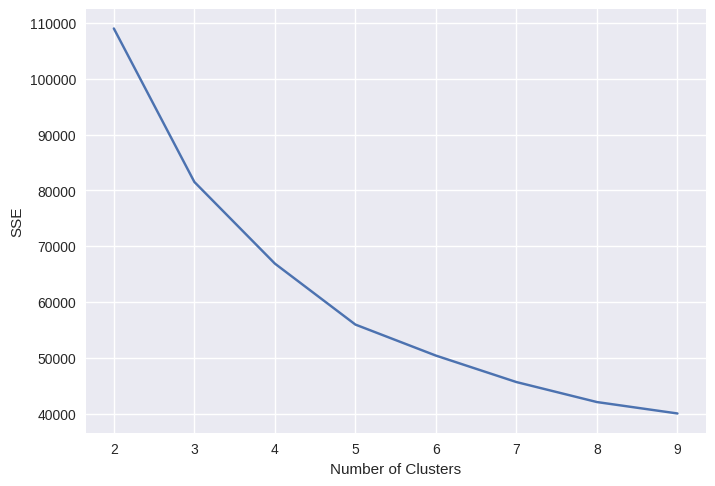

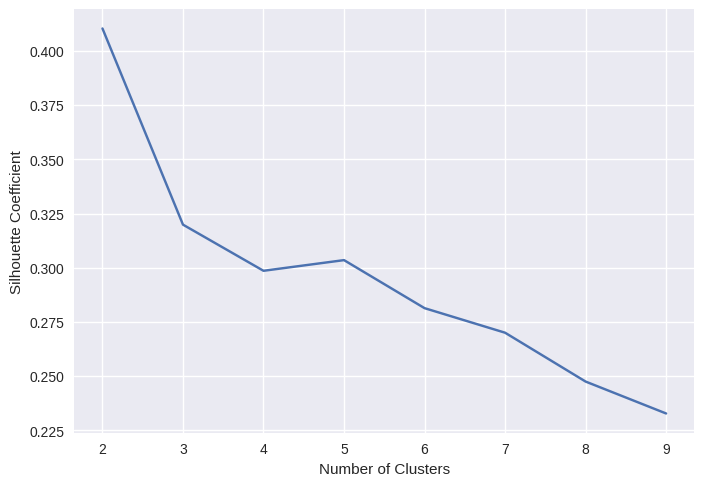

In [75]:
col_to_drop = ['datetime','Longitude', 'Latitude', 'date', 'year', 'TimeOfDay']
Kmeans_ParameterTesting(df_cluster.drop(col_to_drop, axis=1), 10, 20, 50)

## select k=3 - useless

In [76]:
# final_kmeans = KMeans(n_clusters = 3, max_iter=100, n_init=20)
# final_kmeans.fit(df_cluster.drop(col_to_drop, axis=1))

# crimes_near_universities['kmeans_label'] = final_kmeans.labels_
# crimes_near_universities['kmeans_label'].value_counts()

# occurrences = data.groupby(["hour", "Incident Category", label_col]).size().reset_index(name="Occurrences")
# occurrences.sort_values(label_col, inplace=True)
# fig = px.scatter(occurrences, x="hour", y="Incident Category", size="Occurrences", size_max=30, color=label_col)
# fig.show()

In [77]:
final_kmeans = KMeans(n_clusters = 3, max_iter=100, n_init=20)
final_kmeans.fit(df_cluster.drop(col_to_drop, axis=1))

KMeans(max_iter=100, n_clusters=3, n_init=20)

In [78]:
crimes_near_universities['kmeans_label'] = final_kmeans.labels_
crimes_near_universities['kmeans_label'].value_counts()

0    1403
2    1282
1     713
Name: kmeans_label, dtype: int64

In [79]:
def exploreClusters(data, label_col):

  occurrences = data.groupby(["hour", "Incident Category", label_col]).size().reset_index(name="Occurrences")
  occurrences.sort_values(label_col, inplace=True)
  fig = px.scatter(occurrences, x="hour", y="Incident Category", size="Occurrences", size_max=30, color=label_col, width=1000, title='Kmeans Cluster Analysis for Incident Categories and Hours of a day')
  fig.show()

  occurrences = data.groupby(["TimeOfDay", "Incident Category", label_col]).size().reset_index(name="Occurrences")
  occurrences.sort_values(label_col, inplace=True)
  fig = px.scatter(occurrences, x="TimeOfDay", y="Incident Category", size="Occurrences", size_max=30, color=label_col)
  fig.show()

  occurrences = data.groupby(["Incident Category", "IsSchoolDay", label_col]).size().reset_index(name="Occurrences")
  occurrences.sort_values(label_col, inplace=True)
  fig = px.scatter(occurrences, x="Incident Category", y="IsSchoolDay", size="Occurrences",size_max=30, color=label_col)
  fig.show()

  occurrences = data.groupby(["Incident Category", "IsWeekend", label_col]).size().reset_index(name="Occurrences")
  occurrences.sort_values(label_col, inplace=True)
  fig = px.scatter(occurrences, x="Incident Category", y="IsWeekend", size="Occurrences",size_max=30, color=label_col)
  fig.show()

  occurrences = data.groupby(["Incident Category", "dayOfWeek", label_col]).size().reset_index(name="Occurrences")
  occurrences.sort_values(label_col, inplace=True)
  fig = px.scatter(occurrences, x="dayOfWeek", y="Incident Category", size="Occurrences",size_max=30, color=label_col)
  fig.show()

In [80]:
exploreClusters(crimes_near_universities, 'kmeans_label')

In [81]:
def explorePurity(data, col_to_check, label_col):
  # data.sort_values(label_col, inplace=True)
  occurrences = data.groupby([ col_to_check, label_col]).size().reset_index(name="Occurrences")
  percentage_occurrences = (occurrences['Occurrences'] * 100 / occurrences.groupby(col_to_check)['Occurrences'].transform('sum'))
  occurrences['Percentage'] = (percentage_occurrences)

  occurrences.sort_values(label_col, inplace=True)
  # color_discrete_map = {0: 'red', 1: 'blue', 2: 'green'}
  fig = px.bar(occurrences, x=col_to_check, y="Percentage", color=label_col, text_auto=True
              #  , color_discrete_map=color_discrete_map
               )
  fig.update_traces(texttemplate='%{y:.1f}% (%{text})', text=occurrences['Occurrences'])
  fig.show()

Kmeans clustered purely on hours

## k=5 - useless

In [82]:
df_cluster.head()

,datetime,Longitude,Latitude,date,year,hour,TimeOfDay,month,day,DayOfWeek_num,Incident Category_Arson,Incident Category_Assault,Incident Category_Burglary,Incident Category_Case Closure,Incident Category_Disorderly Conduct,Incident Category_Drug Offense,Incident Category_Embezzlement,Incident Category_Forgery And Counterfeiting,Incident Category_Fraud,Incident Category_Larceny Theft,Incident Category_Lost Property,Incident Category_Malicious Mischief,Incident Category_Miscellaneous Investigation,Incident Category_Missing Person,Incident Category_Motor Vehicle Theft,Incident Category_Non-Criminal,Incident Category_Offences Against The Family And Children,Incident Category_Other,Incident Category_Other MIscellaneous,Incident Category_Other Miscellaneous,Incident Category_Other Offenses,Incident Category_Recovered Vehicle,Incident Category_Robbery,Incident Category_Sex Offenses,Incident Category_Stolen Property,Incident Category_Suicide,Incident Category_Suspicious Occ,Incident Category_Traffic Violation,Incident Category_Vandalism,Incident Category_Warrant,Incident Category_Weapon Laws,Incident Category_Weapons Carrying Etc,Incident Category_Weapons Offense,IsWeekend_False,IsWeekend_True,IsSchoolDay_False,IsSchoolDay_True,dayOfWeek_Friday,dayOfWeek_Monday,dayOfWeek_Saturday,dayOfWeek_Sunday,dayOfWeek_Thursday,dayOfWeek_Tuesday,dayOfWeek_Wednesday
2114,2022-10-28 02:50:00,-122.398564,37.788981,2022-10-28,2022,2,Rest,10,31,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0
2657,2023-03-24 15:30:00,-122.398564,37.788981,2023-03-24,2023,15,Afternoon Class,3,31,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0
4528,2023-09-19 23:15:00,-122.400503,37.787450,2023-09-19,2023,23,Rest,9,30,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
5548,2023-10-03 06:29:00,-122.398564,37.788981,2023-10-03,2023,6,Rest,10,31,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
5556,2023-10-03 10:00:00,-122.400809,37.787699,2023-10-03,2023,10,Morning Class,10,31,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0


In [83]:
col_to_drop = ['datetime','Longitude', 'Latitude', 'date', 'year', 'TimeOfDay']

final_kmeans = KMeans(n_clusters = 5, max_iter=100, n_init=20)
final_kmeans.fit(df_cluster.drop(col_to_drop, axis=1))

crimes_near_universities['kmeans_label5'] = final_kmeans.labels_
crimes_near_universities['kmeans_label5'].value_counts()

2    757
3    674
1    664
4    652
0    651
Name: kmeans_label5, dtype: int64

In [84]:
occurrences = crimes_near_universities.groupby(["hour", "Incident Category", 'kmeans_label5']).size().reset_index(name="Occurrences")
occurrences.sort_values('kmeans_label5', inplace=True)
fig = px.scatter(occurrences, x="hour", y="Incident Category", size="Occurrences", size_max=30, color='kmeans_label5')
fig.update_layout(height=800)
fig.show()

In [85]:
occurrences = crimes_near_universities.groupby(["hour", "IsSchoolDay", 'kmeans_label5']).size().reset_index(name="Occurrences")
occurrences.sort_values('kmeans_label5', inplace=True)
fig = px.scatter(occurrences, x="hour", y="IsSchoolDay", size="Occurrences", size_max=30, color='kmeans_label5')
fig.update_layout(height=800)
fig.show()

In [86]:
# occurrences = crimes_near_universities.groupby(["day",'month', 'kmeans_label5']).size().reset_index(name="Occurrences")

# fig = px.scatter(occurrences, x='day', y='month' , size="Occurrences", color='kmeans_label5')
# # fig.update_layout(width=2500, title_text='{}'.format(day))
# # fig.update_xaxes(tickvals='month', ticktext='month')

# fig.show()
crimes_near_universities[crimes_near_universities['kmeans_label5']==0][['day', 'month']].value_counts()

day  month
31   3        125
     1        111
     5        111
30   4        108
     6         90
28   2         73
29   2         26
31   7          7
dtype: int64

# K-Mode Clustering

In [87]:
!pip install kmodes

In [88]:
from kmodes.kmodes import KModes
from kmodes import kprototypes

# caluculate dissimilarity score of two data points
def create_dm(dataset):
    if type(dataset).__name__=='DataFrame':
        dataset=dataset.values
    lenDataset=len(dataset)
    distance_matrix=np.zeros(lenDataset*lenDataset).reshape(lenDataset,lenDataset)
    for i in range(lenDataset):
        for j in range(lenDataset):
            x1= dataset[i].reshape(1,-1)
            x2= dataset[j].reshape(1,-1)
            distance=kprototypes.matching_dissim(x1, x2)
            distance_matrix[i][j]=distance
            distance_matrix[j][i]=distance
    return distance_matrix

def kmode_parameterTesting(data, dist_matrix, max_k, num_init, num_iteration):
  silhouette_scores = dict()
  cost = []
  cluster_range = range(2, max_k)
  for k in list(cluster_range):
      kmode = KModes(n_clusters=k, init = "random", n_init=num_init, max_iter=num_iteration,random_state=2023)
      kmode.fit_predict(data)
      cost.append(kmode.cost_)
      cluster_labels = kmode.labels_
      score=silhouette_score(dist_matrix, cluster_labels, metric="precomputed")
      silhouette_scores[k]=score

  plt.style.use("seaborn")
  plt.plot(cluster_range, cost, 'bx-')
  plt.xlabel('No. of clusters')
  plt.ylabel('Cost')
  plt.title('Elbow Method For Optimal k')
  plt.show()

  plt.style.use("seaborn")
  plt.plot(silhouette_scores.keys(), silhouette_scores.values())
  plt.xlabel("Number of Clusters")
  plt.ylabel("Silhouette Coefficient")
  plt.show()

## Calculate dissimilarity score as distance metric for silhouette score

In [89]:
col_to_drop = ['datetime','Longitude', 'Latitude', 'date', 'year', 'TimeOfDay']
distance_matrix=create_dm(crimes_near_universities.drop(col_to_drop, axis=1))

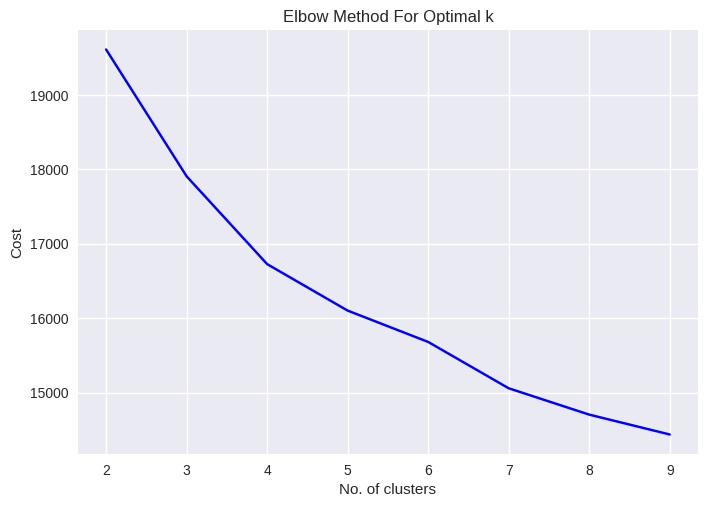

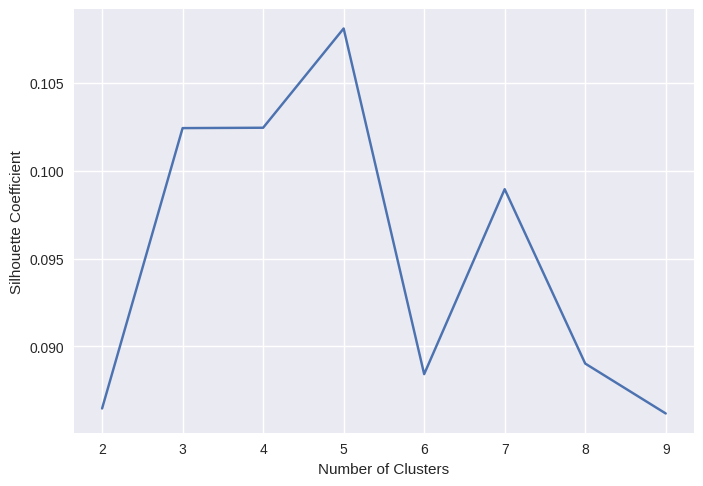

In [90]:
kmode_parameterTesting(crimes_near_universities.drop(col_to_drop, axis=1), distance_matrix, 10, 20, 50)

Conclusion: Investigate k=3, k=4 and k=6 to due to higher silhouette coefficient and lower cost

## K-Modes - k=3

In [91]:
final_kmode = KModes(n_clusters=3, init = "random", n_init = 20, max_iter=50, random_state=2023)
final_kmode.fit_predict(crimes_near_universities.drop(col_to_drop, axis=1))

array([0, 0, 1, ..., 2, 1, 1], dtype=uint16)

In [92]:
crimes_near_universities['kmodes_label3'] = final_kmode.labels_
crimes_near_universities['kmodes_label3'].value_counts()

0    1509
1    1146
2     743
Name: kmodes_label3, dtype: int64

In [93]:
exploreClusters(crimes_near_universities, 'kmodes_label3')

In [94]:
def getLabelCounts(data, col_to_check, label_col):
  # data.sort_values(label_col, inplace=True)
  occurrences = data.groupby([col_to_check, label_col]).size().reset_index(name="Occurrences")
  percentage_occurrences = (occurrences['Occurrences'] * 100 / occurrences.groupby(col_to_check)['Occurrences'].transform('sum'))
  occurrences['Percentage'] = (percentage_occurrences)
  return occurrences

Cluster 0:
- weekend and purely Arson, Drug Offense, Embezzlement, Forgery And Counterfeiting
- mostly 0700-1500

Cluster 1:
- rarely on weekends
- purely 1700-2000, majority 1600-2300

Cluster 2:
- when weekend, purely Other miscellaneous, Weapon Laws, Weapons Offense
- when weekend, majority for most except Cluster 0's category
- mostly 2100-0659



## K-Modes - k=6

In [95]:
final_kmode = KModes(n_clusters=6, init = "random", n_init = 20, max_iter=50, random_state=2023)
final_kmode.fit_predict(crimes_near_universities.drop(col_to_drop, axis=1))

array([1, 3, 2, ..., 0, 2, 2], dtype=uint16)

In [96]:
crimes_near_universities['kmodes_label6'] = final_kmode.labels_
crimes_near_universities['kmodes_label6'].value_counts()

0    760
3    707
2    684
1    623
4    337
5    287
Name: kmodes_label6, dtype: int64

In [97]:
exploreClusters(crimes_near_universities, 'kmodes_label6')

In [98]:
explorePurity(crimes_near_universities, 'hour', 'kmodes_label6')

In [99]:
explorePurity(crimes_near_universities, 'TimeOfDay', 'kmodes_label6')

In [100]:
explorePurity(crimes_near_universities, 'Incident Category', 'kmodes_label6')

# School Semester Analysis

## Kmeans to get an idea of how to cluster hours during the semester

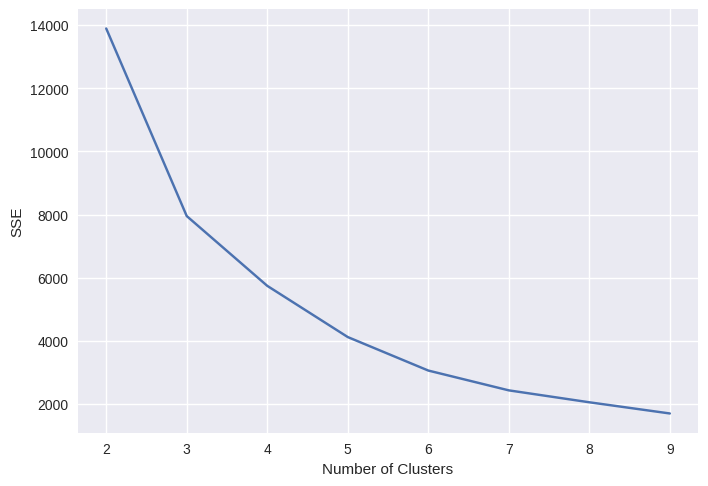

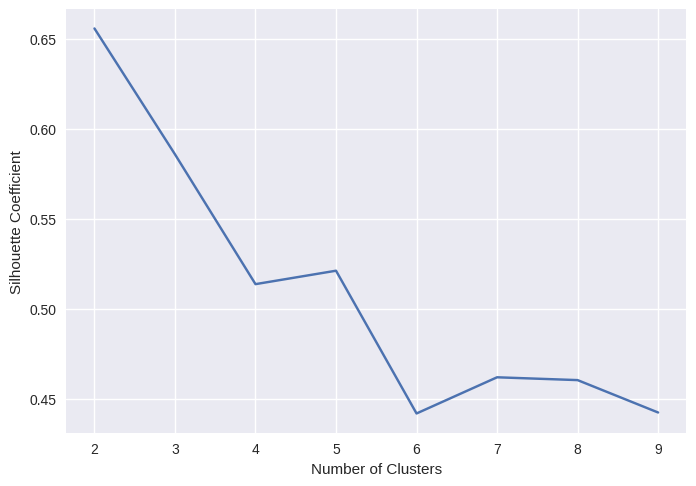

In [101]:
df_school = crimes_near_universities[(crimes_near_universities['IsSchoolDay']==True)].groupby(["hour", 'IsWeekend']).size().reset_index(name="Occurrences")
Kmeans_ParameterTesting(pd.get_dummies(df_school, columns=['IsWeekend']), 10, 20, 50)

In [102]:
final_kmeans = KMeans(n_clusters = 5, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(pd.get_dummies(df_school, columns=['IsWeekend']))

df_school['kmeans_label'] = final_kmeans.labels_
df_school['kmeans_label'].value_counts()

0    24
4     9
1     7
2     7
3     1
Name: kmeans_label, dtype: int64

In [103]:
# occurrences = data.groupby(["hour", "Incident Category", label_col]).size().reset_index(name="Occurrences")
# occurrences.sort_values(label_col, inplace=True)
# fig = px.scatter(occurrences, x="hour", y="Incident Category", size="Occurrences", size_max=30, color=label_col)
# fig.show()
fig = px.bar(df_school[df_school['IsWeekend']==True], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrences on a Weekend in a Semester')
fig.show()
fig = px.bar(df_school[df_school['IsWeekend']==False], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrences on a Weekday in a Semester')
fig.show()
print(type(fig))

<class 'plotly.graph_objs._figure.Figure'>


- Clusters seem to surround highest/high/average/low/lowest levels of crime of a day

  - The norm is true: on weekdays, schooling hours until midnight crimes are at elevated levels
  - However, can notice that on weekends, 2300-0300 are when crimes are elevated

## Hypothesis Testing for Weekend shift

In [104]:
df_school.head()

,hour,IsWeekend,Occurrences,kmeans_label
0,0,False,102,1
1,0,True,43,2
2,1,False,38,2
3,1,True,60,2
4,2,False,36,2


In [105]:
df_school_weekend = df_school[df_school['IsWeekend']==True]
display(shapiro(df_school_weekend['Occurrences']))

ShapiroResult(statistic=0.9287590384483337, pvalue=0.09145686775445938)

Since the p-value >0.05, we reject the null hypothesis. We do not have sufficient evidence to say that the sample data does not come from a normal distribution.



In [106]:
df_midnight = df_school_weekend[df_school_weekend['hour'].isin([23, 0, 1, 2, 3])]['Occurrences'].values
df_nonMidnight = df_school_weekend[df_school_weekend['hour'].isin([23, 0, 1, 2, 3])==False]['Occurrences'].values

# #Levene's test centered at the median
# display(stats.levene(df_evening, df_nonEvening, center='median'))

#Levene's test centered at the mean
display(stats.levene(df_midnight, df_nonMidnight, center='mean'))

LeveneResult(statistic=0.5726455619971365, pvalue=0.45723767580666097)

the p-value >0.05. This means we fail to reject the null hypothesis. This means we do not have sufficient evidence to say that the variance in crime occuring on a weekend midnight and rest of the day is significantly different.

In [107]:
stats.ttest_ind(df_midnight, df_nonMidnight, equal_var=True, alternative='greater')

TtestResult(statistic=6.072133909639244, pvalue=2.0600596294807615e-06, df=22.0)

As p-value < 0.05, we reject null hypothesis that mean of crimes committed during weekend midnight is no difference from mean of crimes committed during rest of the day. Hence, we can statistically prove that mean of occurence of crime is higher during weekend midnight.

## Hypothesis Testing for Weekday shifts

In [108]:
df_school_weekday = df_school[df_school['IsWeekend']==False]
display(shapiro(df_school_weekday['Occurrences']))

ShapiroResult(statistic=0.9479515552520752, pvalue=0.24452529847621918)

Since the p-value >0.05, we reject the null hypothesis. We do not have sufficient evidence to say that the sample data does not come from a normal distribution.

In [109]:
df_active = df_school_weekday[df_school_weekday['hour'].isin(list(range(8,21)))]['Occurrences'].values
df_nonactive = df_school_weekday[df_school_weekday['hour'].isin(list(range(8,21)))==False]['Occurrences'].values

#Levene's test centered at the mean
display(stats.levene(df_active, df_nonactive, center='mean'))

LeveneResult(statistic=1.905053119937815, pvalue=0.18137901472246865)

the p-value >0.05. This means we fail to reject the null hypothesis. This means we do not have sufficient evidence to say that the variance in crime occuring during weekday active hours and non-active hours is significantly different.

In [110]:
stats.ttest_ind(df_active, df_nonactive, equal_var=True, alternative='greater')

TtestResult(statistic=4.782755182641336, pvalue=4.4635246021885354e-05, df=22.0)

Since the p-value <0.05, we reject the null hypothesis. This means we do have sufficient evidence to say that the mean of crimes committed during active hours is greater than mean of crimes committed during non-active hours.

# Non-School Semester Analysis

In [111]:
df_NonSchool = crimes_near_universities[(crimes_near_universities['IsSchoolDay']==False)].groupby(["hour", 'IsWeekend']).size().reset_index(name="Occurrences")
df_NonSchool['Occurrences'].sum()

1041

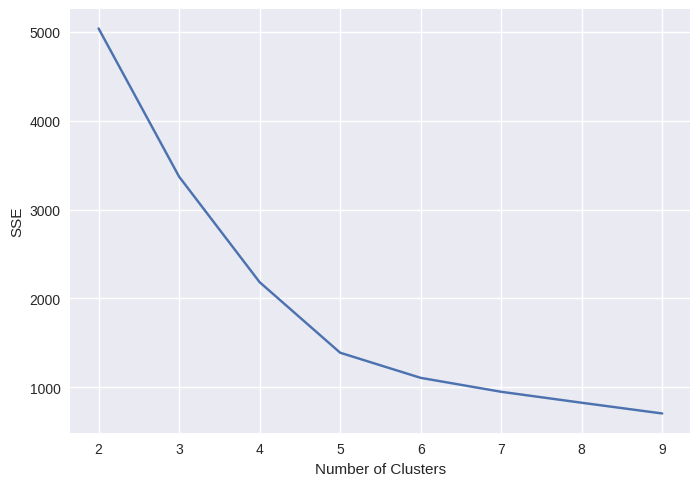

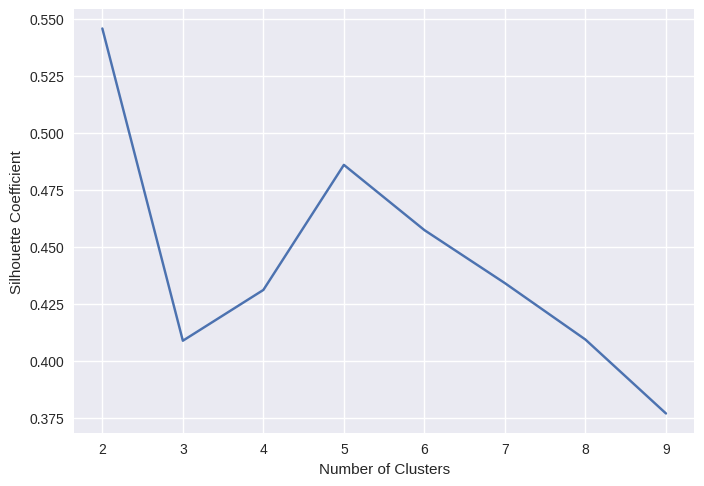

In [112]:
df_NonSchool = crimes_near_universities[(crimes_near_universities['IsSchoolDay']==False)].groupby(["hour", 'IsWeekend']).size().reset_index(name="Occurrences")
Kmeans_ParameterTesting(pd.get_dummies(df_NonSchool, columns=['IsWeekend']), 10, 20, 50)

In [113]:
final_kmeans = KMeans(n_clusters = 5, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(pd.get_dummies(df_NonSchool, columns=['IsWeekend']))

df_NonSchool['kmeans_label'] = final_kmeans.labels_
df_NonSchool['kmeans_label'].value_counts()

3    12
0    11
4     9
2     8
1     8
Name: kmeans_label, dtype: int64

In [114]:
# fig = px.scatter(df_NonSchool, x="hour", y="Incident Category", color='kmeans_label', size='Occurrences', size_max=30)
# fig.update_layout(height=800, title_text='Cluster Analysis')
# fig.show()

In [115]:
fig = px.bar(df_NonSchool[df_NonSchool['IsWeekend']==True], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrence on a Non-Semester Weekend')
fig.show()
fig = px.bar(df_NonSchool[df_NonSchool['IsWeekend']==False], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrence on a Non-Semester Weekday')
fig.show()

## Hypothesis testing for Weekday

In [116]:
df_NonSchool_weekday = df_NonSchool[df_NonSchool['IsWeekend']==False]
display(shapiro(df_NonSchool_weekday['Occurrences']))

ShapiroResult(statistic=0.9514338374137878, pvalue=0.29094547033309937)

Since the p-value >0.05, we reject the null hypothesis. We do not have sufficient evidence to say that the sample data does not come from a normal distribution.


In [117]:
df_NonSchool_day = df_NonSchool_weekday[df_NonSchool_weekday['hour'].isin(list(range(9,19)))]['Occurrences'].values
df_NonSchool_night = df_NonSchool_weekday[df_NonSchool_weekday['hour'].isin(list(range(9,19)))==False]['Occurrences'].values

#Levene's test centered at the mean
display(stats.levene(df_NonSchool_day, df_NonSchool_night, center='mean'))

LeveneResult(statistic=0.5373062430418764, pvalue=0.4712901733327344)

the p-value >0.05. This means we reject the null hypothesis. This means we do not have sufficient evidence to say that the variance in crime occuring during the 2 periods are significantly different.

In [118]:
stats.ttest_ind(df_NonSchool_day, df_NonSchool_night, equal_var=True, alternative='greater')

TtestResult(statistic=5.448290968502566, pvalue=8.960896890383824e-06, df=22.0)

Since the p-value <0.05, we reject the null hypothesis. This means we do have sufficient evidence to say that the mean of crimes committed during day time is greater than mean of crimes committed during night time on weekdays.

## Hypothesis Testing for Weekend

In [119]:
df_NonSchool_weekend = df_NonSchool[df_NonSchool['IsWeekend']==True]
display(shapiro(df_NonSchool_weekend['Occurrences']))

ShapiroResult(statistic=0.9620190858840942, pvalue=0.4803173840045929)

In [120]:
df_NonSchool_rest = df_NonSchool_weekend[df_NonSchool_weekend['hour'].isin(list(range(3,10)))]['Occurrences'].values
df_NonSchool_NonRest = df_NonSchool_weekend[df_NonSchool_weekend['hour'].isin(list(range(3,10)))==False]['Occurrences'].values

#Levene's test centered at the mean
display(stats.levene(df_NonSchool_rest, df_NonSchool_NonRest, center='mean'))

LeveneResult(statistic=0.009738476702555905, pvalue=0.9222830462113828)

the p-value >0.05. This means we reject the null hypothesis. This means we do not have sufficient evidence to say that the variance in crime occuring during the 2 periods are significantly different.

In [121]:
stats.ttest_ind(df_NonSchool_NonRest, df_NonSchool_rest, equal_var=True, alternative='greater')

TtestResult(statistic=3.547915741444664, pvalue=0.0009020317761085547, df=22.0)

Since the p-value <0.05, we reject the null hypothesis. This means we do have sufficient evidence to say that the mean of crimes committed during day time is greater than mean of crimes committed during rest time on weekends.

# Category Analysis

In [122]:
crimes_near_universities[(crimes_near_universities['IsSchoolDay']==True)].groupby(["hour", 'IsWeekend', 'Incident Category']).size().reset_index(name="Occurrences")
# Kmeans_ParameterTesting(pd.get_dummies(df_school, columns=['IsWeekend']), 10, 20, 50)

,hour,IsWeekend,Incident Category,Occurrences
0,0,False,Assault,1
1,0,False,Burglary,6
2,0,False,Case Closure,5
3,0,False,Disorderly Conduct,2
4,0,False,Drug Offense,1
...,...,...,...,...
659,23,True,Non-Criminal,1
660,23,True,Other,7
661,23,True,Other Miscellaneous,1
662,23,True,Robbery,1


In [123]:
 df_category = crimes_near_universities.groupby(["hour", 'IsWeekend', 'Incident Category']).size().reset_index(name="Occurrences")
 df_category['Incident Category'].value_counts()

Larceny Theft                               47
Burglary                                    46
Assault                                     45
Non-Criminal                                43
Vandalism                                   42
Motor Vehicle Theft                         39
Malicious Mischief                          37
Other Miscellaneous                         37
Other                                       36
Traffic Violation                           34
Suspicious Occ                              34
Robbery                                     34
Lost Property                               33
Warrant                                     32
Missing Person                              30
Fraud                                       28
Recovered Vehicle                           21
Miscellaneous Investigation                 20
Drug Offense                                20
Stolen Property                             15
Case Closure                                15
Offences Agai

## Kmeans - useless

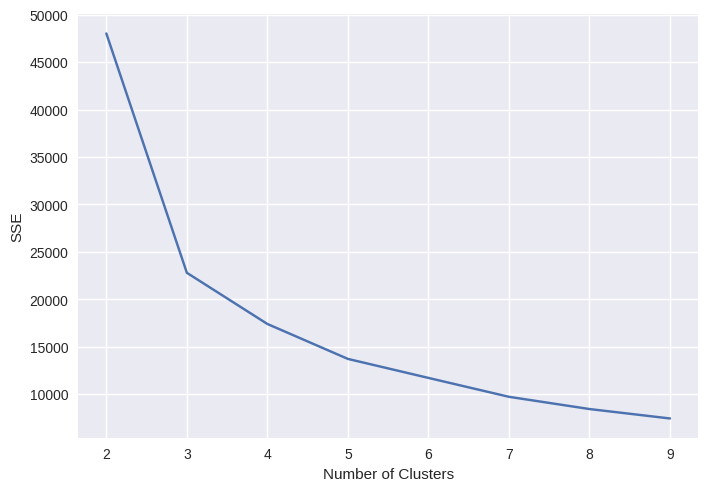

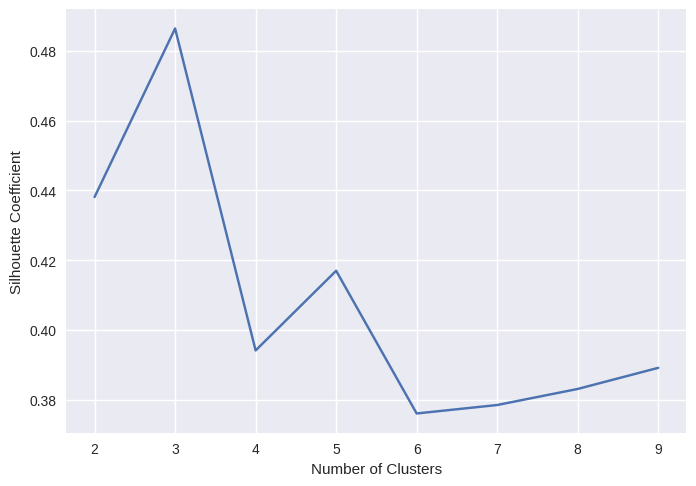

In [124]:
 df_category = crimes_near_universities.groupby(["hour", 'IsWeekend', 'Incident Category']).size().reset_index(name="Occurrences")
 Kmeans_ParameterTesting(pd.get_dummies(df_category, columns=['IsWeekend', 'Incident Category']), 10, 20, 50)

In [125]:
final_kmeans = KMeans(n_clusters = 3, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(pd.get_dummies(df_category, columns=['IsWeekend', 'Incident Category']))

df_category['kmeans_label'] = final_kmeans.labels_
df_category['kmeans_label'].value_counts()

1    387
0    359
2     19
Name: kmeans_label, dtype: int64

In [126]:
fig = px.scatter(df_category, x="hour", y="Incident Category", color='kmeans_label', size='Occurrences', size_max=30)
fig.update_layout(height=800, title_text='Cluster Analysis')
fig.show()

Cluster 0 and 1 is clustered by hours
- cluster 0: 0000 - 1100
- cluster 1: 1200 - 2300

In [127]:
display(df_category[(df_category['kmeans_label']==2)]['Incident Category'].value_counts())
df_category[(df_category['kmeans_label']==2)]['Occurrences'].min()

Larceny Theft    18
Burglary          1
Name: Incident Category, dtype: int64

25

In [128]:
df_category[(df_category['kmeans_label']==2)]['Occurrences'].max()

77

In [129]:
display(df_category[(df_category['kmeans_label']==1)]['Incident Category'].value_counts())
df_category[(df_category['kmeans_label']==1)]['Occurrences'].min()

Burglary                                    23
Assault                                     22
Other                                       21
Vandalism                                   21
Motor Vehicle Theft                         21
Non-Criminal                                21
Other Miscellaneous                         20
Traffic Violation                           19
Suspicious Occ                              19
Malicious Mischief                          19
Missing Person                              19
Lost Property                               18
Warrant                                     17
Robbery                                     16
Fraud                                       16
Larceny Theft                               12
Recovered Vehicle                           11
Drug Offense                                10
Stolen Property                              9
Miscellaneous Investigation                  8
Offences Against The Family And Children     7
Case Closure 

1

In [130]:
display(df_category[(df_category['kmeans_label']==0)]['Incident Category'].value_counts())
df_category[(df_category['kmeans_label']==0)]['Occurrences'].min()

Assault                                     23
Burglary                                    22
Non-Criminal                                22
Vandalism                                   21
Malicious Mischief                          18
Motor Vehicle Theft                         18
Robbery                                     18
Larceny Theft                               17
Other Miscellaneous                         17
Traffic Violation                           15
Other                                       15
Warrant                                     15
Lost Property                               15
Suspicious Occ                              15
Fraud                                       12
Miscellaneous Investigation                 12
Missing Person                              11
Recovered Vehicle                           10
Drug Offense                                10
Case Closure                                 8
Disorderly Conduct                           7
Offences Agai

1

In [131]:
df_category[(df_category['Occurrences']>=25)]['kmeans_label'].value_counts()

2    19
Name: kmeans_label, dtype: int64

In [132]:
fig = px.scatter(df_category[(df_category['kmeans_label']==2)], x="hour", y="Incident Category", color='IsWeekend', size='Occurrences', size_max=30)
# fig.update_layout(height=800)
fig.update_layout(title_text='Cluster 2 IsWeekend and Crime Categories')

fig.show()

In [133]:
# custom_colors = {0:'#6363fa', 1:'#ef553b', 2:'#00cc96'}
# label_colors = ['#6363fa', '#ef553b',  '#00cc96']
fig = px.bar(df_category[(df_category['Incident Category']=='Larceny Theft') & (df_category['IsWeekend']==False)], x="hour", y="Occurrences",
             color='kmeans_label',
             height=400)
fig.show()

fig = px.bar(df_category[(df_category['Incident Category']=='Larceny Theft') & (df_category['IsWeekend']==True)], x="hour", y="Occurrences",
             color='kmeans_label',
             height=400)
fig.show()

can observe that Cluster 2 represents the large occurrences of crime in an hour regardless of weekend/weekday
- As Larceny Theft is the most commonly occured crime, naturally makes up for most of cluster 2
- counts >=25 per hour only

In [134]:
# Filter data for IsWeekend=False
data_weekday = df_category[(df_category['Incident Category'] == 'Larceny Theft') & (df_category['IsWeekend'] == False)]

# Filter data for IsWeekend=True
data_weekend = df_category[(df_category['Incident Category'] == 'Larceny Theft') & (df_category['IsWeekend'] == True)]

# Create a list of unique kmeans_labels
unique_labels = df_category['kmeans_label'].unique()

# Define a list of distinct colors for each label
label_colors = ['#6363fa', '#ef553b',  '#00cc96']

# Create subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=['Weekday', 'Weekend'])

# Add bar chart for Weekday
for i, label in enumerate(unique_labels):
    data = data_weekday[data_weekday['kmeans_label'] == label]
    color = label_colors[i % len(label_colors)]  # Cycle through colors
    fig.add_trace(go.Bar(x=data['hour'], y=data['Occurrences'], name=f'kmeans_label {label}', marker_color=color), row=1, col=1)

# Add bar chart for Weekend
for i, label in enumerate(unique_labels):
    data = data_weekend[data_weekend['kmeans_label'] == label]
    color = label_colors[i % len(label_colors)]  # Cycle through colors
    fig.add_trace(go.Bar(x=data['hour'], y=data['Occurrences'], name=f'kmeans_label {label}', marker_color=color), row=2, col=1)

# Update the layout
fig.update_layout(height=1000, title_text='Larceny Theft Occurrences during hours of a week')

# Show the merged subplot
fig.show()

In [135]:
final_kmeans = KMeans(n_clusters = 5, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(pd.get_dummies(df_category, columns=['IsWeekend', 'Incident Category']))

df_category['kmeans_label5'] = final_kmeans.labels_
df_category['kmeans_label5'].value_counts()

0    262
4    237
1    192
3     56
2     18
Name: kmeans_label5, dtype: int64

In [136]:
fig = px.scatter(df_category, x="hour", y="Incident Category", color='kmeans_label5', size='Occurrences', size_max=30)
fig.update_layout(height=800, title_text='Cluster Analysis')
fig.show()

In [137]:
fig = px.bar(df_category[(df_category['Incident Category']=='Larceny Theft') & (df_category['IsWeekend']==False)], x="hour", y="Occurrences",
             color='kmeans_label5',
             height=400)
fig.show()

fig = px.bar(df_category[(df_category['Incident Category']=='Larceny Theft') & (df_category['IsWeekend']==True)], x="hour", y="Occurrences",
             color='kmeans_label5',
             height=400)
fig.show()

## Kmode - useless

In [138]:
from kmodes.kmodes import KModes
from kmodes import kprototypes

# caluculate dissimilarity score of two data points
def create_dm(dataset):
    if type(dataset).__name__=='DataFrame':
        dataset=dataset.values
    lenDataset=len(dataset)
    distance_matrix=np.zeros(lenDataset*lenDataset).reshape(lenDataset,lenDataset)
    for i in range(lenDataset):
        for j in range(lenDataset):
            x1= dataset[i].reshape(1,-1)
            x2= dataset[j].reshape(1,-1)
            distance=kprototypes.matching_dissim(x1, x2)
            distance_matrix[i][j]=distance
            distance_matrix[j][i]=distance
    return distance_matrix

def kmode_parameterTesting(data, dist_matrix, max_k, num_init, num_iteration):
  silhouette_scores = dict()
  cost = []
  cluster_range = range(2, max_k)
  for k in list(cluster_range):
      kmode = KModes(n_clusters=k, init = "random", n_init=num_init, max_iter=num_iteration,random_state=2023)
      kmode.fit_predict(data)
      cost.append(kmode.cost_)
      cluster_labels = kmode.labels_
      score=silhouette_score(dist_matrix, cluster_labels, metric="precomputed")
      silhouette_scores[k]=score

  plt.style.use("seaborn")
  plt.plot(cluster_range, cost, 'bx-')
  plt.xlabel('No. of clusters')
  plt.ylabel('Cost')
  plt.title('Elbow Method For Optimal k')
  plt.show()

  plt.style.use("seaborn")
  plt.plot(silhouette_scores.keys(), silhouette_scores.values())
  plt.xlabel("Number of Clusters")
  plt.ylabel("Silhouette Coefficient")
  plt.show()

In [139]:
df_category.head()

,hour,IsWeekend,Incident Category,Occurrences,kmeans_label,kmeans_label5
0,0,False,Assault,5,0,1
1,0,False,Burglary,10,0,1
2,0,False,Case Closure,6,0,1
3,0,False,Disorderly Conduct,2,0,1
4,0,False,Drug Offense,1,0,1


In [140]:
# Dissimilarity score
col_to_drop = ['kmeans_label', 'kmeans_label5']
distance_matrix=create_dm(df_category.drop(col_to_drop, axis=1))

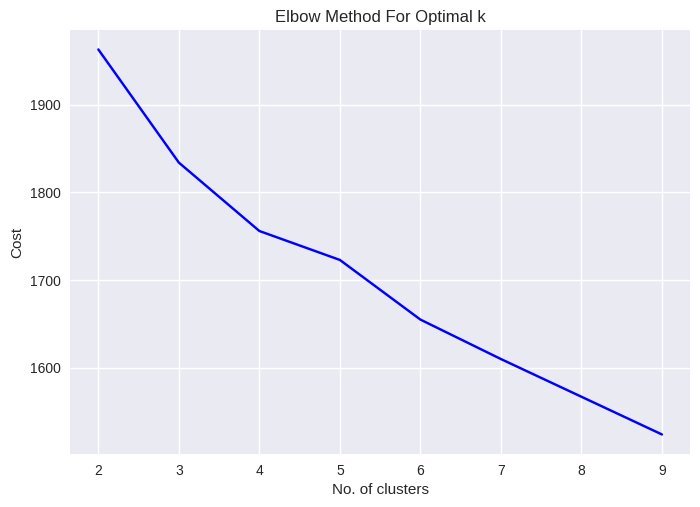

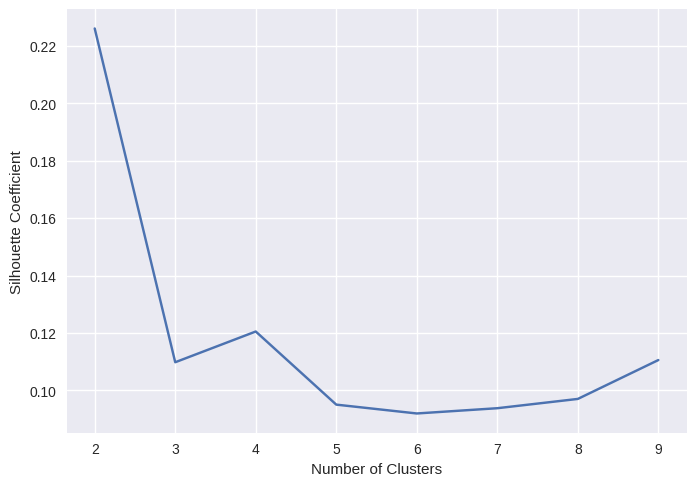

In [141]:
kmode_parameterTesting(df_category.drop(col_to_drop, axis=1), distance_matrix, 10, 20, 50)

In [142]:
final_kmode = KModes(n_clusters=4, init = "random", n_init = 20, max_iter=50, random_state=2023)
final_kmode.fit_predict(df_category.drop(col_to_drop, axis=1))

df_category['kmodes_label'] = final_kmode.labels_
df_category['kmodes_label'].value_counts()

0    294
1    247
2    145
3     79
Name: kmodes_label, dtype: int64

In [143]:
fig = px.scatter(df_category, x="hour", y="Incident Category", color='kmodes_label', size='Occurrences', size_max=30)
fig.update_layout(height=800, title_text='Cluster Analysis')
fig.show()

In [144]:
fig = px.bar(df_category[(df_category['Incident Category']=='Larceny Theft') & (df_category['IsWeekend']==False)], x="hour", y="Occurrences",
             color='kmodes_label',
             height=400)
fig.show()

fig = px.bar(df_category[(df_category['Incident Category']=='Larceny Theft') & (df_category['IsWeekend']==True)], x="hour", y="Occurrences",
             color='kmodes_label',
             height=400)
fig.show()

## Larceny Theft (during semester)

In [145]:
df_theft = crimes_near_universities[(crimes_near_universities['Incident Category']=='Larceny Theft') & (crimes_near_universities['IsSchoolDay']==True)].groupby(["hour", 'IsWeekend']).size().reset_index(name="Occurrences")
df_theft.head()


,hour,IsWeekend,Occurrences
0,0,False,28
1,0,True,16
2,1,False,5
3,1,True,23
4,2,False,3


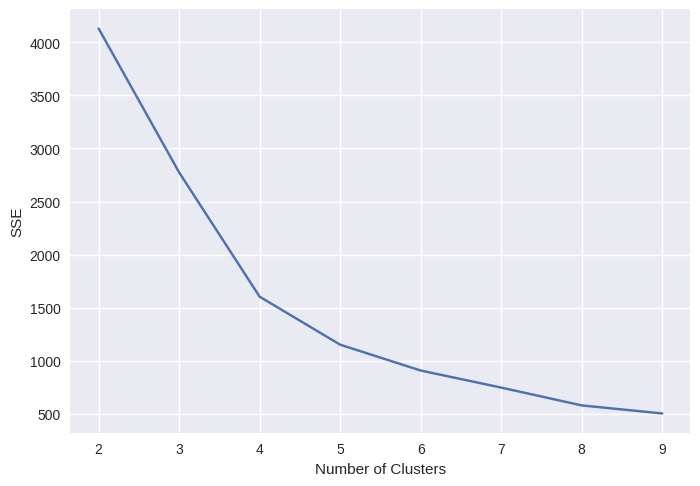

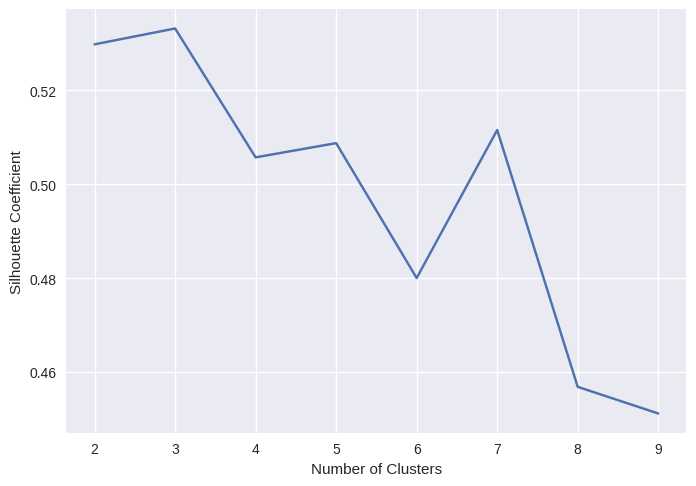

In [146]:
Kmeans_ParameterTesting(pd.get_dummies(df_theft, columns=['IsWeekend']), 10, 20, 50)

### Kmeans: k=3 - useless

In [147]:
final_kmeans = KMeans(n_clusters = 3, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(pd.get_dummies(df_theft, columns=['IsWeekend']))

df_theft['kmeans_label'] = final_kmeans.labels_
df_theft['kmeans_label'].value_counts()

1    29
0    16
2     2
Name: kmeans_label, dtype: int64

In [148]:
fig = px.scatter(df_theft, x="hour", y="kmeans_label", color='kmeans_label', size='Occurrences', size_max=50)
fig.update_layout(height=800, title_text='Cluster Analysis')
fig.show()

In [149]:
fig = px.scatter(df_theft, x="hour", y="IsWeekend", color='kmeans_label', size='Occurrences', size_max=30)
fig.update_layout(height=800, title_text='Cluster Analysis')
fig.show()

In [150]:
fig = px.bar(df_theft[(df_theft['IsWeekend']==False)], x="hour", y="Occurrences",
             color='kmeans_label',
             height=400,  title='Larceny Theft on School Weekdays')
fig.show()

fig = px.bar(df_theft[(df_theft['IsWeekend']==True)], x="hour", y="Occurrences",
             color='kmeans_label',
             height=400, title='Larceny Theft on School Weekends')
fig.show()

Not very useful/clear clusters

### kmeans: k=5

In [151]:
final_kmeans = KMeans(n_clusters = 5, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(pd.get_dummies(df_theft, columns=['IsWeekend']))

df_theft['kmeans_label5'] = final_kmeans.labels_
df_theft['kmeans_label5'].value_counts()

0    17
1    14
2    11
4     3
3     2
Name: kmeans_label5, dtype: int64

In [152]:
fig = px.scatter(df_theft, x="hour", y="kmeans_label", color='kmeans_label5', size='Occurrences', size_max=50)
fig.update_layout(height=800, title_text='Cluster Analysis')
fig.show()

In [153]:
fig = px.scatter(df_theft, x="hour", y="IsWeekend", color='kmeans_label5', size='Occurrences', size_max=30)
fig.update_layout(height=800, title_text='Cluster Analysis')
fig.show()

In [154]:
fig = px.bar(df_theft[(df_theft['IsWeekend']==False)], x="hour", y="Occurrences",
             color='kmeans_label5',
             width=1000,  title='Larceny Theft on School Weekdays')
fig.show()

fig = px.bar(df_theft[(df_theft['IsWeekend']==True)], x="hour", y="Occurrences",
             color='kmeans_label5',
             width=1000, title='Larceny Theft on School Weekends')
fig.show()

does take into consideration hour and levels of occurrence
- 13th hour deem part of the other cluster which has generally higher levels
- can tell is not only clustered based on hour as on weekend the clusters are done differently

### Hypothesis Testing For Larceny Theft (Semester Weekday) - 0800 - 0059 (obvious to the eye)

In [155]:
df_theft.head()

,hour,IsWeekend,Occurrences,kmeans_label,kmeans_label5
0,0,False,28,0,4
1,0,True,16,1,4
2,1,False,5,1,0
3,1,True,23,0,4
4,2,False,3,1,0


In [156]:
df_theft_weekday = df_theft[df_theft['IsWeekend']==False]
display(shapiro(df_theft_weekday['Occurrences']))

ShapiroResult(statistic=0.9060349464416504, pvalue=0.028957849368453026)

Since the p-value <0.05, we fail toreject the null hypothesis. We do have sufficient evidence to say that the sample data does not come from a normal distribution.

In [157]:
df_theft_NonSleep = df_theft_weekday[df_theft_weekday['hour'].isin(list(range(1,8)))==False]['Occurrences'].values
df_theft_sleep = df_theft_weekday[df_theft_weekday['hour'].isin(list(range(1,8)))]['Occurrences'].values

In [158]:
stats.mannwhitneyu(df_theft_NonSleep, df_theft_sleep, alternative='greater')

MannwhitneyuResult(statistic=119.0, pvalue=8.4319575215736e-05)

As p-value < 0.05, we reject null hypothesis that mean of crimes committed during the 2 periods of he day are the same. Hence, we can statistically prove that mean of occurence of crime is higher during non-sleeping hours for weekdays.

### Hypothesis Testing For Larceny Theft (Semester Weekend) - 1300-0159

In [159]:
df_theft_weekend = df_theft[df_theft['IsWeekend']==True]
display(shapiro(df_theft_weekend['Occurrences']))

ShapiroResult(statistic=0.9191620945930481, pvalue=0.0639253556728363)

Since the p-value >0.05, we reject the null hypothesis. We do not have sufficient evidence to say that the sample data does not come from a normal distribution.

In [160]:
df_theft_nonMorning = df_theft_weekend[df_theft_weekend['hour'].isin(list(range(2,13)))==False]['Occurrences'].values
df_theft_Morning = df_theft_weekend[df_theft_weekend['hour'].isin(list(range(2,13)))]['Occurrences'].values

#Levene's test centered at the mean
display(stats.levene(df_theft_nonMorning, df_theft_Morning, center='mean'))

LeveneResult(statistic=2.3797559045209056, pvalue=0.13785248102368966)

the p-value >0.05. This means we fail to reject the null hypothesis. This means we do not have sufficient evidence to say that the variance in crime occuring during the 2 periods is significantly different.

In [161]:
stats.ttest_ind(a=df_theft_nonMorning, b=df_theft_Morning, equal_var=True, alternative='greater')

TtestResult(statistic=3.983353239572701, pvalue=0.0003380367895327489, df=21.0)

As p-value < 0.05, we reject null hypothesis that mean of crimes committed during the 2 perios is no difference. Hence, we can statistically prove that mean of occurence of crime is higher during active hours for weekdays.

## Larceny Theft (Non-Semester)

In [194]:
df_theft_nonSchool = crimes_near_universities[(crimes_near_universities['Incident Category']=='Larceny Theft') & (crimes_near_universities['IsSchoolDay']==False)].groupby(["hour", 'IsWeekend']).size().reset_index(name="Occurrences")

fig = px.bar(df_theft_nonSchool[(df_theft_nonSchool['IsWeekend']==False)], x="hour", y="Occurrences",
            #  color='kmeans_label5',
             height=400,  title='Larceny Theft on non-School Weekdays')
fig.show()

fig = px.bar(df_theft[(df_theft['IsWeekend']==False)], x="hour", y="Occurrences",
            #  color='kmeans_label5',
             height=400,  title='Larceny Theft on School Weekdays')
fig.show()

In [193]:
fig = px.bar(df_theft_nonSchool[(df_theft_nonSchool['IsWeekend']==True)], x="hour", y="Occurrences",
            #  color='kmeans_label5',
             height=400, title='Larceny Theft on non-School Weekends')
fig.show()

fig = px.bar(df_theft[(df_theft['IsWeekend']==True)], x="hour", y="Occurrences",
            #  color='kmeans_label5',
             height=400, title='Larceny Theft on School Weekends')
fig.show()

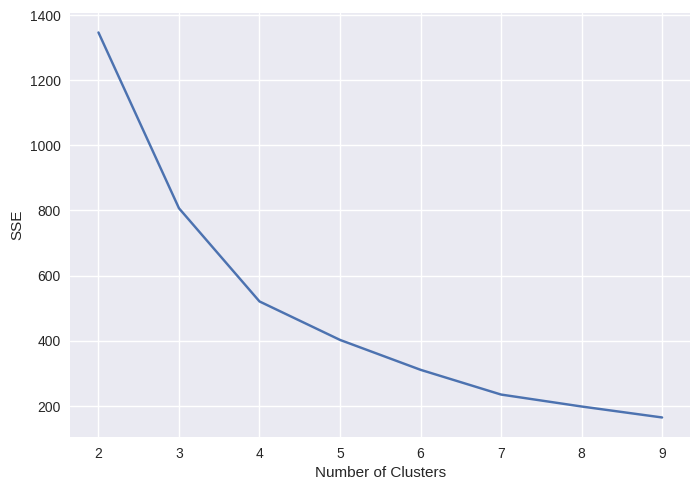

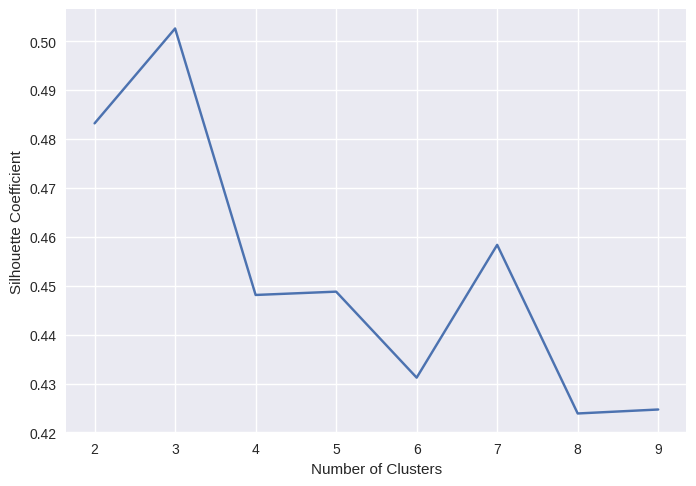

In [195]:
Kmeans_ParameterTesting(pd.get_dummies(df_theft_nonSchool, columns=['IsWeekend']), 10, 20, 50)

### K-Means: k=3

In [196]:
final_kmeans = KMeans(n_clusters = 3, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(pd.get_dummies(df_theft_nonSchool, columns=['IsWeekend']))

df_theft_nonSchool['kmeans_label'] = final_kmeans.labels_
df_theft_nonSchool['kmeans_label'].value_counts()

0    22
1    13
2    10
Name: kmeans_label, dtype: int64

In [199]:
fig = px.bar(df_theft_nonSchool[(df_theft_nonSchool['IsWeekend']==False)], x="hour", y="Occurrences",
             color='kmeans_label',
             height=400,  title='Larceny Theft on Non-School Weekdays')
fig.show()

fig = px.bar(df_theft_nonSchool[(df_theft_nonSchool['IsWeekend']==True)], x="hour", y="Occurrences",
             color='kmeans_label',
             height=400, title='Larceny Theft on Non-School Weekends')
fig.show()

for weekdays it seems useful, but on weekdays it seems to be only clustered by hour

### K-Means: k=7

In [198]:
final_kmeans = KMeans(n_clusters = 7, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(pd.get_dummies(df_theft_nonSchool, columns=['IsWeekend']))

df_theft_nonSchool['kmeans_label7'] = final_kmeans.labels_
df_theft_nonSchool['kmeans_label7'].value_counts()

0    9
2    8
4    6
1    6
5    6
3    6
6    4
Name: kmeans_label7, dtype: int64

In [200]:
fig = px.bar(df_theft_nonSchool[(df_theft_nonSchool['IsWeekend']==False)], x="hour", y="Occurrences",
             color='kmeans_label7',
             height=400,  title='Larceny Theft on Non-School Weekdays')
fig.show()

fig = px.bar(df_theft_nonSchool[(df_theft_nonSchool['IsWeekend']==True)], x="hour", y="Occurrences",
             color='kmeans_label7',
             height=400, title='Larceny Theft on Non-School Weekends')
fig.show()

weekends have too little counts and many preiods are roughly similar to have an optimal shift

### Hypothesis Testing for Larceny on Weekdays - 1200-2259

In [202]:
df_theft_nonSchool_weekday = df_theft_nonSchool[df_theft_nonSchool['IsWeekend']==False]
display(shapiro(df_theft_nonSchool_weekday['Occurrences']))

ShapiroResult(statistic=0.9458243250846863, pvalue=0.23921982944011688)

Since the p-value >0.05, we reject the null hypothesis. We do not have sufficient evidence to say that the sample data does not come from a normal distribution.

In [206]:
df_theft_nonSchool_weekday_active = df_theft_nonSchool_weekday[df_theft_nonSchool_weekday['hour'].isin(list(range(12,23)))]['Occurrences'].values
df_theft_nonSchool_weekday_nonActive = df_theft_nonSchool_weekday[df_theft_nonSchool_weekday['hour'].isin(list(range(12,23)))==False]['Occurrences'].values

#Levene's test centered at the mean
display(stats.levene(df_theft_nonSchool_weekday_active, df_theft_nonSchool_weekday_nonActive, center='mean'))

LeveneResult(statistic=1.8541043854314518, pvalue=0.18773761776354952)

the p-value >0.05. This means we fail to reject the null hypothesis. This means we do not have sufficient evidence to say that the variance in crime occuring during the 2 periods is significantly different.

In [207]:
stats.ttest_ind(df_theft_nonSchool_weekday_active, df_theft_nonSchool_weekday_nonActive, equal_var=True, alternative='greater')

TtestResult(statistic=7.362827282080115, pvalue=1.5170842133724767e-07, df=21.0)

As p-value < 0.05, we reject null hypothesis that mean of crimes committed during the 2 perios is no difference. Hence, we can statistically prove that mean of occurence of crime is higher during active hours for weekdays.

## Kmeans for Lost Property (Semester)

In [165]:
df_lost = crimes_near_universities[(crimes_near_universities['Incident Category']=='Lost Property')& (crimes_near_universities['IsSchoolDay']==True)].groupby(['hour', 'IsWeekend']).size().reset_index(name="Occurrences")
df_lost.head()

,hour,IsWeekend,Occurrences
0,0,False,3
1,0,True,1
2,1,False,2
3,1,True,3
4,2,False,1


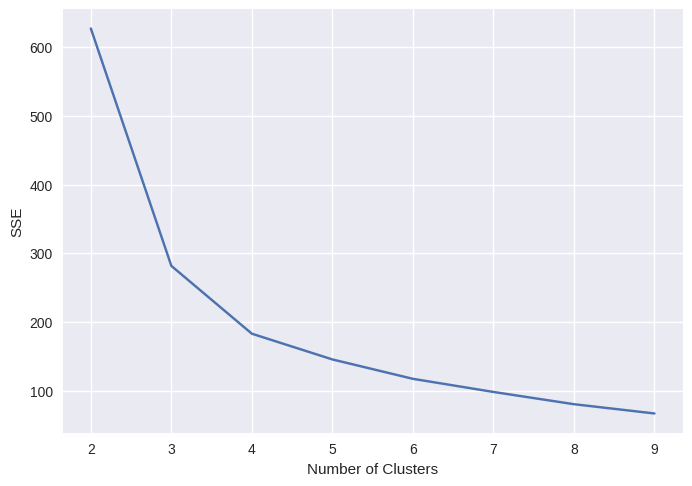

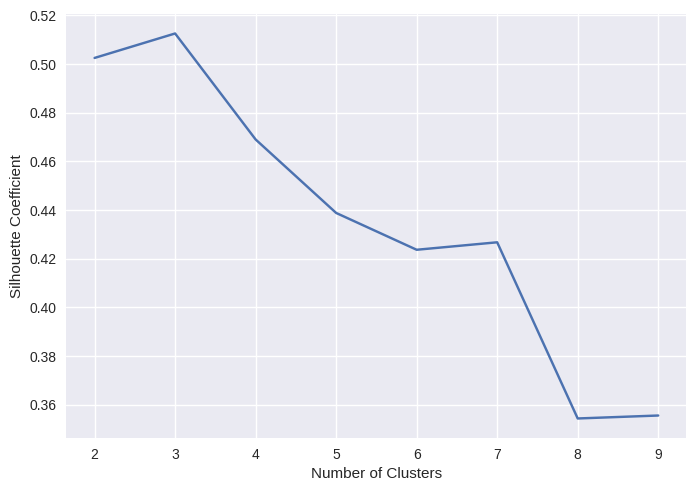

In [166]:
Kmeans_ParameterTesting(pd.get_dummies(df_lost, columns=['IsWeekend']), 10, 20, 50)

### k=3 - useless

In [167]:
final_kmeans = KMeans(n_clusters = 3, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(pd.get_dummies(df_lost, columns=['IsWeekend']))

df_lost['kmeans_label'] = final_kmeans.labels_
df_lost['kmeans_label'].value_counts()

2    13
0    12
1     8
Name: kmeans_label, dtype: int64

In [168]:
fig = px.bar(df_lost[(df_lost['IsWeekend']==False)], x="hour", y="Occurrences",
             color='kmeans_label',
             height=400,  title='Lost Property on School Weekdays')
fig.show()

fig = px.bar(df_lost[(df_lost['IsWeekend']==True)], x="hour", y="Occurrences",
             color='kmeans_label',
             height=400, title='Lost Property on School Weekends')
fig.show()

Only Clustered by hour, no relevance to occurrence levels

### k=4 - useless

In [169]:
final_kmeans = KMeans(n_clusters = 4, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(pd.get_dummies(df_lost, columns=['IsWeekend']))

df_lost['kmeans_label'] = final_kmeans.labels_
df_lost['kmeans_label'].value_counts()

2    9
3    9
1    8
0    7
Name: kmeans_label, dtype: int64

In [170]:
fig = px.bar(df_lost[(df_lost['IsWeekend']==False)], x="hour", y="Occurrences",
             color='kmeans_label',
             height=400,  title='Lost Property on School Weekdays')
fig.show()

fig = px.bar(df_lost[(df_lost['IsWeekend']==True)], x="hour", y="Occurrences",
             color='kmeans_label',
             height=400, title='Lost Property on School Weekends')
fig.show()

seem to only be clustered by hours also

# Time Series Analysis

## by days in school

In [174]:
crimes_near_universities['dayOfWeek_num'] = crimes_near_universities['datetime'].dt.day_of_week
occurrence = crimes_near_universities[(crimes_near_universities['IsSchoolDay']==True)].groupby(['dayOfWeek_num']).size().reset_index(name="Occurrences")
occurrence.sort_values('dayOfWeek_num', inplace=True)
fig = px.bar(occurrence, x="dayOfWeek_num", y="Occurrences",
            #  color='kmeans_label',
             height=400, title='Lost Property on School Weekends')
fig.show()

In [175]:
crimes_near_universities['month'] = crimes_near_universities['datetime'].dt.month

occurrence = crimes_near_universities[(crimes_near_universities['IsSchoolDay']==True)].groupby(['month']).size().reset_index(name="Occurrences")
occurrence.sort_values('month', inplace=True)
fig = px.bar(occurrence, x="month", y="Occurrences",
            #  color='kmeans_label',
             height=400, title='Lost Property on School Weekends')
fig.show()

In [176]:
crimes_near_universities['dayOfYear'] = crimes_near_universities['datetime'].dt.day_of_year

In [177]:
crimes_near_universities['date'] = pd.to_datetime(crimes_near_universities['date'])

In [178]:
df_day = crimes_near_universities[(crimes_near_universities['IsSchoolDay']==True)].groupby(['date', 'dayOfWeek']).size().reset_index(name="Occurrences")
df_day.head()

,date,dayOfWeek,Occurrences
0,2003-01-01,Wednesday,2
1,2003-01-02,Thursday,1
2,2003-01-06,Monday,2
3,2003-01-08,Wednesday,2
4,2003-01-16,Thursday,3


In [179]:
crimes_near_universities['weekOfYear'] = crimes_near_universities['datetime'].dt.week

In [180]:
df_time = crimes_near_universities.groupby(['year', 'weekOfYear', 'IsSchoolDay']).size().reset_index(name="Occurrences")
df_time.sort_values(['IsSchoolDay', 'year'], inplace=True)

for year in df_time['year'].unique():
  fig = px.bar(df_time[df_time['year']==year], x='weekOfYear', y="Occurrences", color=df_time[df_time['year']==year]['IsSchoolDay'])
  fig.update_layout(width=1000, title_text='{}'.format(year))
  # fig.update_xaxes(tickvals=df_time[df_time['year']==year]['date'].dt.year, ticktext=df_time[df_time['dayOfWeek']==df_time]['date'].dt.year)

  fig.show()

In [181]:
occurrence = crimes_near_universities.groupby(['weekOfYear', 'IsSchoolDay']).size().reset_index(name="Occurrences")
occurrence.sort_values('weekOfYear', inplace=True)
fig = px.bar(occurrence, x="weekOfYear", y="Occurrences",
            #  color='kmeans_label',
             height=600, title='Crime levels based on week of theyear', color='IsSchoolDay')
fig.show()

In [182]:
occurrences = crimes_near_universities.groupby(["TimeOfDay"]).size().reset_index(name="Occurrences")

day_order = ['Rest', 'Morning Class', 'Lunch','Afternoon Class', 'Dinner']

# Create a bar chart with the specified order
fig = px.bar(
    occurrences,
    x="TimeOfDay",
    y="Occurrences",
    category_orders={"TimeOfDay": day_order},
    title='Occurrences by Time of Day',
)

fig.show()

In [183]:
# May be interesting to explore these
bins = [0, 6, 12, 18, 21, 24]
labels = ['Midnight', 'Morning', 'Afternoon', 'Evening', 'Night']
crimes_near_universities['TimeOfDay'] = pd.cut(crimes_near_universities['hour'], bins=bins, labels=labels, right=False)

a = crimes_near_universities.groupby('TimeOfDay').size()
a = a/a.sum() * 100
a = a.reset_index(name = 'Count')

fig = px.line(a, x="TimeOfDay", y="Count")

fig.update_layout(
    title='Distribution of Crime Categories by Time of Day(%)',
    xaxis_title='Day of Week',
    yaxis_title='Percentage (%)',
    xaxis_tickangle= -60
)

fig.show()


## Kmeans for time

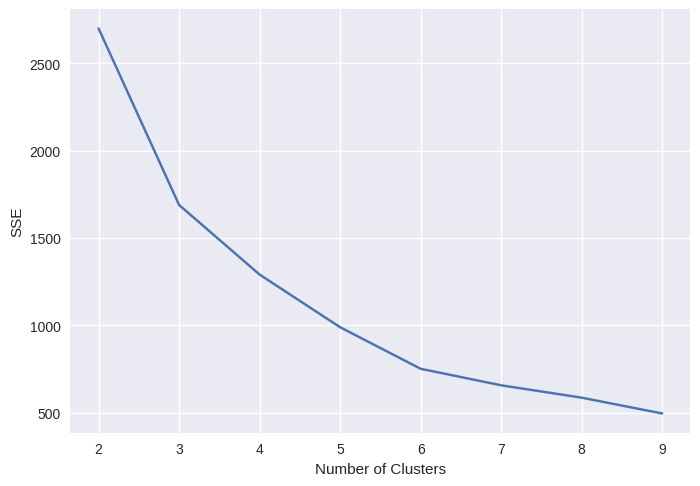

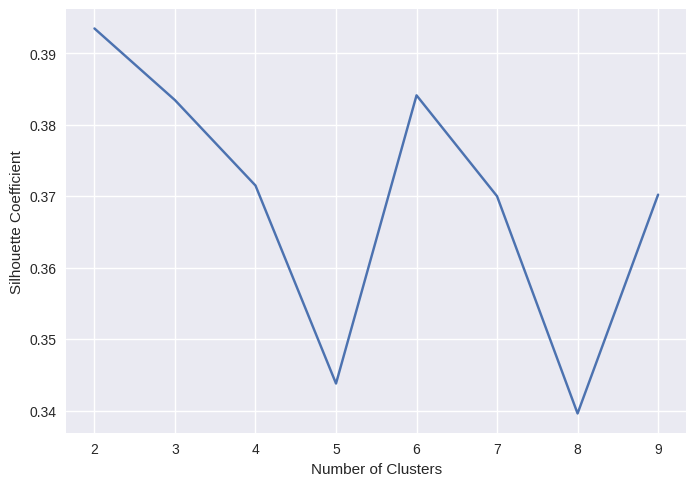

In [184]:
df_time = crimes_near_universities[(crimes_near_universities['IsSchoolDay']==True)].groupby(['month', 'dayOfWeek_num']).size().reset_index(name="Occurrences")

Kmeans_ParameterTesting(df_time, 10, 20, 50)

### k=3 - useless

In [185]:
final_kmeans = KMeans(n_clusters = 3, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(df_time)

df_time['kmeans_label'] = final_kmeans.labels_
df_time['kmeans_label'].value_counts()

0    27
1    25
2     4
Name: kmeans_label, dtype: int64

In [186]:
fig = px.scatter(df_time, x='month', y="dayOfWeek_num", size='Occurrences', color='kmeans_label', size_max=30)
# fig.update_layout(width=2500, title_text='{}'.format(day))
# fig.update_xaxes(tickvals=df_day[df_day['dayOfWeek']==day]['date'].dt.year, ticktext=df_day[df_day['dayOfWeek']==day]['date'].dt.year)

fig.show()

### k=5

In [187]:
final_kmeans = KMeans(n_clusters = 5, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(df_time)

df_time['kmeans_label'] = final_kmeans.labels_
df_time['kmeans_label'].value_counts()

2    15
1    14
3    14
0     9
4     4
Name: kmeans_label, dtype: int64

In [188]:
fig = px.scatter(df_time, x='month', y="dayOfWeek_num", size='Occurrences', color='kmeans_label', size_max=30, title='Kmeans cluster for Month and Day of Week')
# fig.update_layout(width=2500, title_text='{}'.format(day))
# fig.update_xaxes(tickvals=df_day[df_day['dayOfWeek']==day]['date'].dt.year, ticktext=df_day[df_day['dayOfWeek']==day]['date'].dt.year)
fig.update_layout(width=1000)
fig.show()

In [189]:
time_indexed = crimes_near_universities.set_index('datetime')
time_indexed.sort_index(inplace=True)

monthly_counts = time_indexed.resample('M').size()
monthly_counts = monthly_counts.reset_index(name = 'Count')

fig = px.line(monthly_counts, x='datetime', y='Count',
              labels = {
                  'DateTime': 'Year',
                  'Count': 'Number of Crimes'
              },
              title = "Number of crimes committed by month")
fig.show()

yearly_counts = time_indexed.resample('Y').size()
yearly_counts = yearly_counts.reset_index(name = 'Count')
fig = px.line(yearly_counts, x='datetime', y='Count', labels = {
                  'DateTime': 'Year',
                  'Count': 'Number of Crimes'
              },
              title = "Number of crimes committed by year")
fig.show()

In [190]:
condition1 = ((crimes_near_universities['datetime'].dt.month == 8) & (crimes_near_universities['datetime'].dt.day >= 15)) | \
             (crimes_near_universities['datetime'].dt.month > 8) & (crimes_near_universities['datetime'].dt.month < 12) | \
             ((crimes_near_universities['datetime'].dt.month == 12) & (crimes_near_universities['datetime'].dt.day <= 10))

condition2 = ((crimes_near_universities['datetime'].dt.month == 1) & (crimes_near_universities['datetime'].dt.day >= 15)) | \
             (crimes_near_universities['datetime'].dt.month > 1) & (crimes_near_universities['datetime'].dt.month < 5) | \
             ((crimes_near_universities['datetime'].dt.month == 5) & (crimes_near_universities['datetime'].dt.day <= 10))

combined_condition = condition1 | condition2

filtered_index = crimes_near_universities[combined_condition].index
crimes_near_universities.loc[filtered_index,'SchoolIsInSession'] = 1
crimes_near_universities['SchoolIsInSession'].fillna(0, inplace = True)

in_session_data = crimes_near_universities[crimes_near_universities['SchoolIsInSession'] == 1]
not_in_session_data = crimes_near_universities[crimes_near_universities['SchoolIsInSession'] == 0]

time_indexed_1 = in_session_data.set_index('datetime')
time_indexed_0 = not_in_session_data.set_index('datetime')
time_indexed_1.sort_index(inplace=True)
time_indexed_0.sort_index(inplace=True)

monthly_counts_1 = time_indexed_1.resample('M').size()
monthly_counts_0 = time_indexed_0.resample('M').size()
monthly_counts_1 = monthly_counts_1.reset_index(name = 'Count')
monthly_counts_0 = monthly_counts_0.reset_index(name = 'Count')

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_counts['datetime'],
    y=monthly_counts['Count'],
    mode='lines',
    name='Not in Session',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=monthly_counts_1['datetime'],
    y=monthly_counts_1['Count'],
    mode='lines',
    name='In Session',
    line=dict(color='red')
))

fig.update_layout(
    title='Daily Crime Occurrences Over Time',
    xaxis_title='Date',
    yaxis_title='Crime Count'
)

fig.show()